# CanESM5 GMD paper Figure 4




In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import iris
import iris.analysis.cartography
import modules.plotting_module as pltm

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
%store -r color_dict
%store -r label_fontsize
%store -r legend_fontsize

In [3]:
#file locations
cmip_dir = 'input_data/CanESM5_cmip_dir/' 
scenariomip_dir = 'input_data/CanESM5_scenariomip_dir'

his_file   = os.path.join(cmip_dir, 'historical/r1i1p1f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc')
co24x_file = os.path.join(cmip_dir, 'abrupt-4xCO2/r1i1p1f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_abrupt-4xCO2_r1i1p1f1_gn_185001-200012.nc')
ppy1_file  = os.path.join(cmip_dir, '1pctCO2/r1i1p1f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc')
ssp585_file  = os.path.join(scenariomip_dir, 'ssp585/r1i1p1f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc')
ssp370_file  = os.path.join(scenariomip_dir, 'ssp370/r1i1p1f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_ssp370_r1i1p1f1_gn_201501-210012.nc')
ssp245_file  = os.path.join(scenariomip_dir, 'ssp245/r1i1p1f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_ssp245_r1i1p1f1_gn_201501-210012.nc')
ssp126_file  = os.path.join(scenariomip_dir, 'ssp126/r1i1p1f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_ssp126_r1i1p1f1_gn_201501-210012.nc')
pictrl_file1 = os.path.join(cmip_dir, 'piControl/r1i1p1f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-540012.nc')
pictrl_file2 = os.path.join(cmip_dir, 'piControl/r1i1p1f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_piControl_r1i1p1f1_gn_540101-560012.nc')

In [4]:
#load data in iris cubes and get global means (avgd in space)

file_list = [his_file, co24x_file, ppy1_file, ssp585_file, ssp370_file, ssp245_file, ssp126_file, [pictrl_file1,pictrl_file2]]
expts = ['historical','4xco2','1ppy','SSP5-8.5','SSP3-7','SSP2-4.5','SSP1-2.6','picontrol']

iris_cubes = {}
for file, expt in zip(file_list,expts):
    if expt == 'picontrol':
        cube_list = iris.cube.CubeList([iris.load_cube(file[0]), iris.load_cube(file[1])])
        for raw_cube in cube_list:
            for attr in ['creation_date', 'tracking_id', 'history']: #need to remove these as they differ from file to file and iris won't concatenate to a single cube if any attrs differ
                if attr in raw_cube.attributes:
                    del raw_cube.attributes[attr]
        cube = cube_list.concatenate_cube()
    else:
        cube = iris.load_cube(file)
        
    grid_areas = iris.analysis.cartography.area_weights(cube)
    means = cube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN,  weights=grid_areas)
    iris_cubes[expt] = {'global_mean':means}

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(message % (variable_name, nc_var_name))
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(message % (variable_name, nc_var_name))
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/iris/fileformats/cf

In [5]:
#convert to xarrays and get month weighted annual means plus 11-year rolling mean of annual means

for expt in iris_cubes:
    mean_xr   =  xr.DataArray.from_iris(iris_cubes[expt]['global_mean']) 
    annmeans  = pltm.get_month_weighted_annual_means(mean_xr, 'noleap', mean_xr.time.min(), '5450-01-01')-273.15 #set enddate as 5450-01-01 to truncate picontrol run
    rolling_11yr = annmeans.rolling(year=11,center=True).mean()

    iris_cubes[expt]['annmeans'] = annmeans
    iris_cubes[expt]['rolling_11yr'] = rolling_11yr

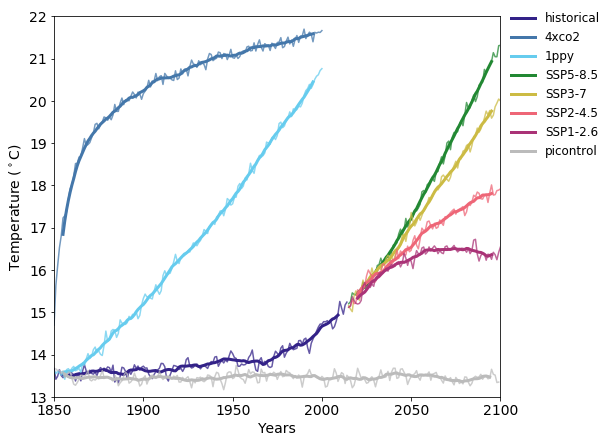

In [6]:
#plotting

fig, ax = plt.subplots(1, 1, figsize=(8,7))


for expt in iris_cubes:   
    if expt == 'picontrol':
        ax.plot(iris_cubes[expt]['annmeans'].year-3350, iris_cubes[expt]['annmeans'], color=color_dict[expt], alpha=0.75)
        ax.plot(iris_cubes[expt]['rolling_11yr'].year-3350, iris_cubes[expt]['rolling_11yr'], color=color_dict[expt], linewidth=3, label=expt)
    else:
        ax.plot(iris_cubes[expt]['annmeans'].year, iris_cubes[expt]['annmeans'], color=color_dict[expt], alpha=0.75)
        ax.plot(iris_cubes[expt]['rolling_11yr'].year, iris_cubes[expt]['rolling_11yr'], color=color_dict[expt], linewidth=3,label=expt)
        
ax.set_xlabel('Years')
ax.set_ylabel(r'Temperature ($^\circ$C)')
ax.set_yticks(np.arange(13,25,1))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.82), fontsize=legend_fontsize, frameon=False)
ax.set_xlim(1850,2100)
ax.set_ylim(13,22)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(label_fontsize)

plt.savefig('plots/fig-02_screen_temps.png', bbox_inches='tight')
plt.savefig('plots/fig-02_screen_temps.pdf', bbox_inches='tight')